# 실습 1: OOD 탐지 - 예외 상황 감지

CIFAR-10으로 학습된 모델이 SVHN과 같은 다른 도메인의 이미지를 예외 상황(OOD)으로 감지

## 1. 필요한 라이브러리 설치 및 임포트

In [10]:
!pip install torch torchvision torchaudio
!pip install timm
!pip install matplotlib
!pip install numpy

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import timm
from torch.utils.data import DataLoader

## 2. 데이터셋 준비

CIFAR-10(In-distribution)과 SVHN(Out-of-distribution) 데이터셋 로드

In [15]:
# 데이터 전처리 설정
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# CIFAR-10 데이터셋 로드 (In-distribution)
cifar10_test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                          download=True, transform=transform)
cifar10_loader = DataLoader(cifar10_test, batch_size=100, shuffle=False)

# SVHN 데이터셋 로드 (Out-of-distribution)
svhn_test = torchvision.datasets.SVHN(root='./data', split='test',
                                     download=True, transform=transform)
svhn_loader = DataLoader(svhn_test, batch_size=100, shuffle=False)

Files already downloaded and verified
Using downloaded and verified file: ./data\test_32x32.mat


## 3. 사전 학습된 모델 로드

CIFAR-10으로 사전 학습된 ResNet 모델 로드

In [17]:
# ResNet 모델 로드
model = timm.create_model('resnet18', pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 10)  # CIFAR-10 클래스 수에 맞게 수정

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device).eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

## 4. OOD 탐지 함수 구현

Softmax confidence 기반의 OOD 탐지 함수를 구현

In [18]:
def is_ood(output, threshold=0.7):
    probs = torch.nn.functional.softmax(output, dim=1)
    max_conf, _ = torch.max(probs, dim=1)
    return max_conf < threshold, max_conf

## 5. OOD 탐지 실험 실행

CIFAR-10(In-distribution)과 SVHN(Out-of-distribution) 데이터에 대해 OOD 탐지를 수행.

In [21]:
def evaluate_ood_detection(dataloader, model, threshold=0.7):
    ood_scores = []
    
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(device)
            outputs = model(images)
            _, confidences = is_ood(outputs, threshold)
            ood_scores.extend(confidences.cpu().numpy())
    
    return np.array(ood_scores)

# CIFAR-10과 SVHN에 대한 OOD 점수 계산
cifar10_scores = evaluate_ood_detection(cifar10_loader, model)
svhn_scores = evaluate_ood_detection(svhn_loader, model)

## 6. 결과 시각화

In-distribution(CIFAR-10)과 Out-of-distribution(SVHN) 데이터의 confidence 분포.

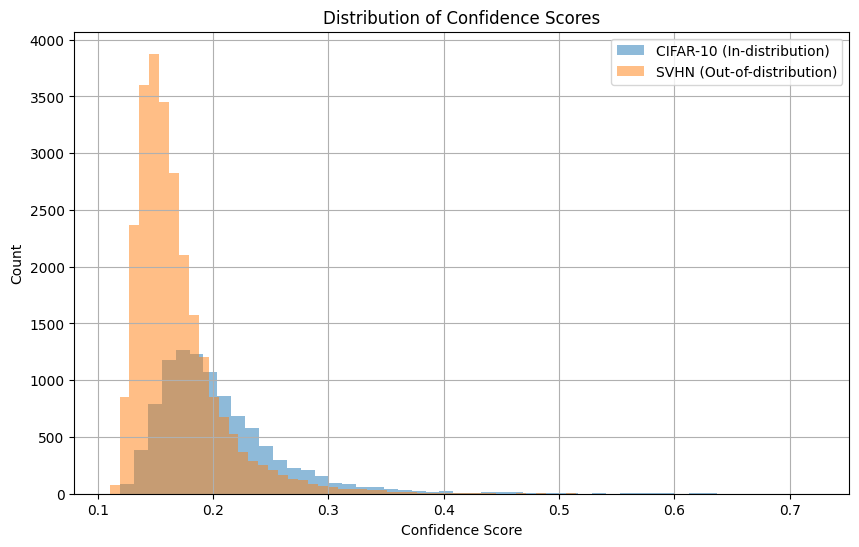

In [22]:
plt.figure(figsize=(10, 6))
plt.hist(cifar10_scores, bins=50, alpha=0.5, label='CIFAR-10 (In-distribution)')
plt.hist(svhn_scores, bins=50, alpha=0.5, label='SVHN (Out-of-distribution)')
plt.xlabel('Confidence Score')
plt.ylabel('Count')
plt.title('Distribution of Confidence Scores')
plt.legend()
plt.grid(True)
plt.show()

## 7. OOD 탐지 성능 평가

다양한 threshold 값에 대한 OOD 탐지 성능 평가.

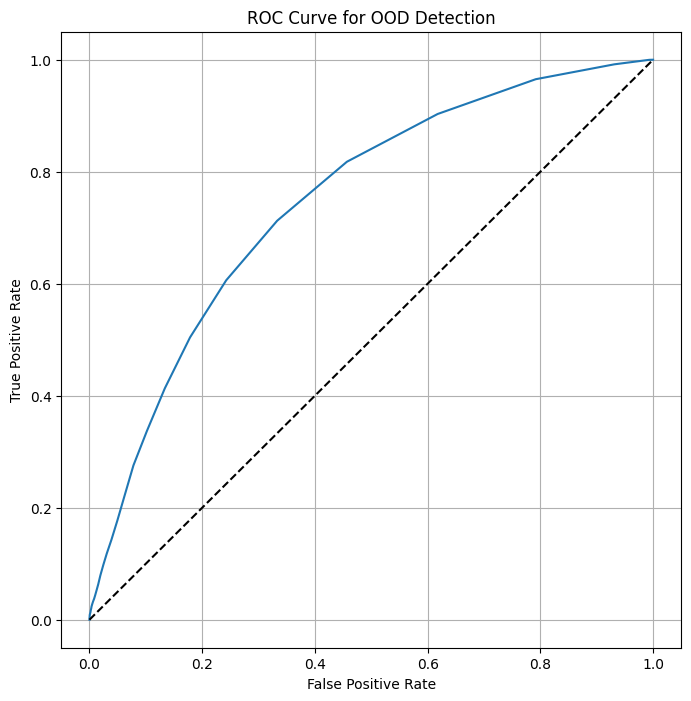

In [23]:
def calculate_metrics(cifar10_scores, svhn_scores, threshold):
    # True Positive Rate (TPR): In-distribution 데이터를 올바르게 분류
    tpr = np.mean(cifar10_scores >= threshold)
    
    # False Positive Rate (FPR): Out-of-distribution 데이터를 잘못 분류
    fpr = np.mean(svhn_scores >= threshold)
    
    return tpr, fpr

# 다양한 threshold 값에 대한 성능 평가
thresholds = np.linspace(0, 1, 100)
tprs, fprs = [], []

for threshold in thresholds:
    tpr, fpr = calculate_metrics(cifar10_scores, svhn_scores, threshold)
    tprs.append(tpr)
    fprs.append(fpr)

# ROC 곡선 시각화
plt.figure(figsize=(8, 8))
plt.plot(fprs, tprs)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for OOD Detection')
plt.grid(True)
plt.show()

## 8. OOD 데이터 버퍼 구현

OOD로 탐지된 이미지를 저장하는 버퍼

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


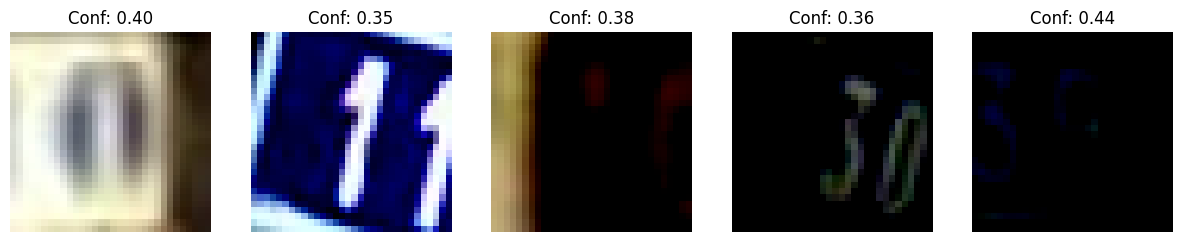

In [25]:
class OODBuffer:
    def __init__(self, max_size=1000):
        self.max_size = max_size
        self.buffer = []
        self.confidences = []
    
    def add(self, image, confidence):
        if len(self.buffer) >= self.max_size:
            # 가장 낮은 confidence를 가진 샘플 제거
            min_idx = np.argmin(self.confidences)
            self.buffer.pop(min_idx)
            self.confidences.pop(min_idx)
        
        self.buffer.append(image)
        self.confidences.append(confidence)
    
    def get_samples(self):
        return self.buffer, self.confidences

# OOD 버퍼 생성 및 테스트
ood_buffer = OODBuffer(max_size=100)

# SVHN 데이터셋에서 OOD 샘플 수집
with torch.no_grad():
    for images, _ in svhn_loader:
        images = images.to(device)
        outputs = model(images)
        is_ood_samples, confidences = is_ood(outputs)
        
        # OOD로 탐지된 샘플을 버퍼에 추가
        for i, (is_ood_sample, confidence) in enumerate(zip(is_ood_samples, confidences)):
            if is_ood_sample:
                ood_buffer.add(images[i].cpu(), confidence.cpu())

# 수집된 OOD 샘플 시각화
samples, confidences = ood_buffer.get_samples()
if len(samples) > 0:
    plt.figure(figsize=(15, 5))
    for i, (sample, conf) in enumerate(zip(samples[:5], confidences[:5])):
        plt.subplot(1, 5, i+1)
        plt.imshow(sample.permute(1, 2, 0).numpy())
        plt.title(f'Conf: {conf:.2f}')
        plt.axis('off')
    plt.show()